In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### <font color='3C89F9'><b>Загрузка данных</b></font>

In [2]:
# загрузка данных для классификации
path_file = 'example_data.xlsx'
sheet_name = 'example_load'

data = pd.read_excel(path_file, sheet_name=sheet_name)
print(data.shape)

# data = pd.read_csv('E:/Projects/Python/PythonUp64/Jupyter/MachineLearning/tennis_predict/out.csv')
# data.rename(columns={'p1iswin': 'label'}, inplace=True)
# data['idx'] = range(0, data.shape[0])

(891, 14)


In [3]:
# просмотр столбцов
data.columns

Index(['idx', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Family', 'isAlone', 'label'],
      dtype='object')

In [4]:
# проверка на необходимые столбцы
if not set(['idx','label']).issubset(data.columns):
    raise Exception('не хватает необходимых столбцов')

# проверка на уникальность индекса
if not data['idx'].is_unique:
    raise Exception('индексы должны быть уникальными')

In [5]:
# присвоение индекса
if 'idx' in data:
    if not data['idx'].is_unique:
        raise Exception('входные индексы имеют дубликаты')
    data.set_index(['idx'], inplace=True)

In [6]:
# смотрим на данные
print('размерность:', data.shape)
data.head(4)

размерность: (891, 13)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,isAlone,label
idx,,,,,,,,,,,,,
1,3,0,0,2,1,0,0,0,0,0,2,0,0
2,1,2,1,4,1,0,1,1,1,1,2,0,1
3,3,1,1,3,0,0,0,0,0,0,1,1,1
4,1,2,1,4,1,0,0,0,1,0,2,0,1


### <font color='3C89F9'><b>Preprocessing</b></font>

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# # масштабирование данных - нормализация (минимакс)
# scaler = MinMaxScaler(feature_range=(0.1, 0.9))
# scaled_features = scaler.fit_transform(data[data.columns.difference(['label'])].astype('float64'))
# scaled_data = pd.DataFrame(data=scaled_features, index=data.index, columns=data.drop(['label'], axis=1).columns)
# scaled_data['label'] = data['label']
# scaled_data.head(4)

# # масштабирование данных - стандартизация
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(data[data.columns.difference(['label'])].astype('float64'))
# scaled_data = pd.DataFrame(data=scaled_features, index=data.index, columns=data.drop(['label'], axis=1).columns)
# scaled_data['label'] = data['label']
# scaled_data.head(4)

# оставить без масштабирования
scaled_data = data.copy()
scaled_data.head(4)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,isAlone,label
idx,,,,,,,,,,,,,
1,3,0,0,2,1,0,0,0,0,0,2,0,0
2,1,2,1,4,1,0,1,1,1,1,2,0,1
3,3,1,1,3,0,0,0,0,0,0,1,1,1
4,1,2,1,4,1,0,0,0,1,0,2,0,1


In [8]:
# замена пустых значений
scaled_data.fillna(value=0, inplace=True)

### <font color='3C89F9'><b>Подготовка данных к ML</b></font>

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_data = scaled_data.drop('label', axis=1).select_dtypes(include=[np.number])
y_data = scaled_data['label'].astype('int32')

print('size train data:', X_data.shape)
print('size train labels:', y_data.shape)

size train data: (891, 12)
size train labels: (891,)


In [11]:
# разбивка на тестовые и тренировочные данные
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

### <font color='3C89F9'><b>Модель - Random forest</b></font>

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

# модели случайный лес
from sklearn.ensemble import RandomForestClassifier

In [13]:
# случайный лес
rf = RandomForestClassifier(max_features='auto', random_state=1, n_jobs=-1, n_estimators=10)

In [14]:
# посмотрим на примерный результат, без поиска лучших гиперпараметров
print(np.mean(cross_val_score(rf, X_data, y_data, cv=5)))

0.81040532494121


In [15]:
# оптимизируемые параметры (по каким будет идти перебор)
rf_params = {'criterion' : ['entropy'],
             'min_samples_leaf' : [1,2,3],
             'min_samples_split' : [5,15,25,50,100],
             'n_estimators': [50,75,100,125,150]}

In [16]:
# объект для поиска наилучших параметров
rf_grid = GridSearchCV(rf,
                       rf_params,
                       cv=5,
                       n_jobs=-1,
                       verbose=True)

### <font color='3C89F9'><b>Поиск лучших гиперпараметров</b></font>

In [17]:
# поиск наилучших параметров для модели
rf_grid.fit(X_train, y_train);

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.0min finished


In [18]:
# просмотр лучших параметров
rf_grid.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'n_estimators': 50}

In [19]:
# просмотр лучшего результата
rf_grid.best_score_

0.8300561797752809

In [20]:
# просмотр комбинация гиперпараметров с оценками
means = rf_grid.cv_results_['mean_test_score']
stds = rf_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.826 (+/-0.028) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.819 (+/-0.035) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 75}
0.823 (+/-0.028) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.822 (+/-0.034) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 125}
0.819 (+/-0.043) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
0.819 (+/-0.037) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.820 (+/-0.028) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
0.813 (+/-0.032) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 75}
0.816 (+/-0.035) for {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split':

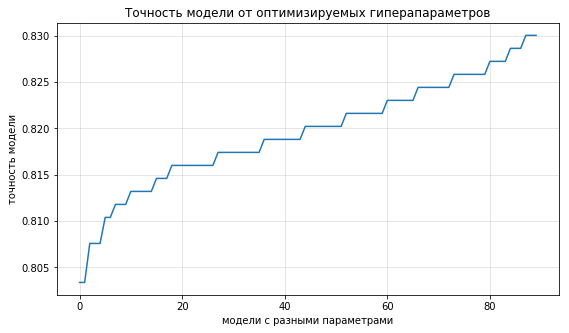

In [21]:
plt.subplots(figsize=(9,5))
plt.plot(np.sort(rf_grid.cv_results_['mean_test_score']));
plt.grid(alpha=0.4)
plt.ylabel('точность модели');
plt.xlabel('модели с разными параметрами');
plt.title('Точность модели от оптимизируемых гиперапараметров');

### <font color='3C89F9'><b>Построение модели с оптимизированными гиперпараметрами</b></font>

In [22]:
# отбираем лучшую модель
best_model = rf_grid.best_estimator_

In [23]:
# обучаем модель на всех данных
best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [24]:
# смотрим на результативность на тестовых данных
best_model.score(X_test, y_test)

0.8379888268156425

In [41]:
# pd.DataFrame(data=best_model.predict(X_test)).to_clipboard()

In [40]:
# pd.DataFrame(data=y_test).to_clipboard()

In [39]:
# pd.DataFrame(data=X_test).to_clipboard()

In [25]:
# сформируем важности признаков
imp_df = pd.DataFrame(best_model.feature_importances_,
                      columns=['Feature_Imp'],
                      index=X_train.columns)
imp_df.sort_values(by=['Feature_Imp'], ascending=False, inplace=True)
print(imp_df)

          Feature_Imp
Name         0.312300
Sex          0.206405
Pclass       0.122622
Age          0.080789
Cabin        0.074441
Family       0.050777
Ticket       0.046303
Fare         0.036778
SibSp        0.023282
Embarked     0.022313
Parch        0.014683
isAlone      0.009307


In [155]:
# df_temp = pd.DataFrame(data=np.arange(80).reshape(20,4), columns=list('abcd'))
# df_temp.iloc[np.random.choice(df_temp.shape[0], df_temp.shape[0], replace=False)]